In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
import nltk
from collections import defaultdict, deque
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import brown #brown dataset required
import regex
import matplotlib.pyplot as plt
import copy 
from nltk import bigrams, trigrams
import sqlite3
#np.random.seed(1234)
#tf.random.set_seed(1234)
nltk.download('stopwords')
nltk.download('brown')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\hamil\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


Get Sentences from Corpus

In [2]:
def get_sentences_with_fids(corpus=brown,start=32000,end=42000): #WORKS
  fid_sentences = {}
  count = 0
  sentences = set(tuple(row) for row in corpus.sents()[start:end])
  sentences_list = [row for row in corpus.sents()[start:end]]
  fidCounter = -1
  found = -1
  for fid in corpus.fileids():
    fidCounter+=1
    sent = [row for row in corpus.sents(fileids=fid)]
    #genre_sentences[cat] = defaultdict(lambda:0)
    sent_tuple = set(tuple(row) for row in sent)
    
    
    if(sent_tuple.issubset(sentences)):
      if(count==0 and sent!=sentences_list[:len(sent)]):#The first FID will more than likely not start at our start length
        for i in range(0,end-start-len(sent)):
          for j in range(0,len(sent)):
            if(sent[j]!=sentences_list[j+i]):
              break
            if(j==len(sent)-1):
              found=i
          if(found>-1):
            found = i
            break
        if(found<0):
          print("ERROR in get_sentences_with_fid1, set not found")
          return None 
        count+=found    
      fid_sentences[fid] = sent
      count+=len(sent)
  if(found>-1 or count<(end-start-1)):
    first_fid = set(tuple(row) for row in sentences_list[:found])
    last_fid = set(tuple(row) for row in sentences_list[count:])
    for fid in corpus.fileids():
      if(found==-1 and count>(end-start-1)):
        break
      if fid in fid_sentences.keys():
        continue
      sent = corpus.sents(fileids=fid)
      sent_tuple = set(tuple(row) for row in sent)
      if(first_fid.issubset(sent_tuple)):
        fid_sentences[fid] = sentences_list[:found]
        found = -1
      if(last_fid.issubset(sent_tuple)):
        fid_sentences[fid] = sentences_list[count:]
        count+=len(sentences_list[count:])

  return fid_sentences

Generate Cipher Code and other Cipher related methods

In [3]:
def generate_cipher(seed:int=1234):
  rng = np.random.default_rng(seed)
  encode_key = {}
  letters = 'abcdefghijklmnopqrstuvwxyz'
  letters_to_match = 'abcdefghijklmnopqrstuvwxyz'
  for c in letters:
    char = rng.integers(0,len(letters_to_match))
    encode_key[c] = letters_to_match[char:char+1]
    letters_to_match = letters_to_match.replace(letters_to_match[char:char+1],"")
  decode_key = {}
  for c in encode_key:
    decode_key[encode_key[c]]=c
  return encode_key,decode_key

def substitution_cipher(plaintext:str,seed:int=1234):
  encode_key,decode_key = generate_cipher(seed)
  cipher = ''
  for c in plaintext.lower():
    if(c in encode_key.keys()):
      cipher+=encode_key[c]
    else:
      cipher+=c
  return cipher,decode_key

def decode_cipher(ciphertext,decode_key):
  plaintext = ''
  for c in ciphertext:
    if(c in decode_key.keys()):
      plaintext+=decode_key[c]
    else:
      plaintext+=c
  return plaintext

def letter_frequency(ciphertext):
  dist = defaultdict(lambda:0)
  for letter in ciphertext:
    if letter.isalpha():
      dist[letter]+=1
  freq = {k: v for k, v in sorted(dist.items(), key=lambda item: item[1])}
  return freq

<B>Preprocess Methods

In [4]:
def remove_punct(word:str):
  punct = "\":,.!?()%;\\1234567890*&[{]}/#^$`~_=+"
  for char in punct:
    word = word.replace(char,"")
  return word
def process_sentence(sentence,lower:bool=True):
  #stemmer = PorterStemmer()
  new_sentence = []
  #stem_sentence = [stemmer.stem(word) for word in sentence] #Stem words
  #for word in sentence:
  for word in sentence:
    word_span = regex.match("([[:punct:]])*",word).span() #remove punctuation
    numeral_or_character = ((word.lower()==word.upper()))
    if((word_span[0] == 0 and word_span[1] == len(word)) or numeral_or_character): #If the 'word' is punctuation, dont add it to processed_sentences
      continue
    new_word=remove_punct(word)
    if(new_word==""):
      break
    if(lower):
      new_sentence.append(new_word.lower())
    else:
      new_sentence.append(new_word)
  #new_sentence.append("<E>")
  return new_sentence

def preprocess_data(fid):#INPUT IS DICTIONARY[FID]:Document which is made up of [[Sentence]]
  # TODO: Add preprocessing steps (tokenization, normalization, etc.)
  processed_sentences = []
  vocab = set()#defaultdict(lambda:{"<S>","<E>"})
  vocab.add("<S>")
  vocab.add("<E>")
  for docs in fid:
    for sentence in fid[docs]:
      new_sentence = process_sentence(sentence)
      if(len(new_sentence)==0):
        continue
      for word in new_sentence:
        vocab.add(word.lower())
      processed_sentences.append(new_sentence)
  return processed_sentences, vocab

<B>Get Processed Sentences and Shuffle them

In [5]:
fid = get_sentences_with_fids(start=0,end=-1)

In [6]:
processed_sentences, vocab = preprocess_data(fid)
np.random.shuffle(processed_sentences) #randomizes sentences
# training = processed_sentences[:int(len(processed_sentences)*.8)]
# validation = processed_sentences[int(len(processed_sentences)*.8):int(len(processed_sentences)*.9)]
# testing = processed_sentences[int(len(processed_sentences)*.9):]

<B>Process sentences into ciphers and partially deciphered ciphers for RNN to decode

In [13]:
MAX_LEN = 250
MIN_LEN = 10
def generate_cipher(seed:int=1234):
  rng = np.random.default_rng(seed)
  encode_key = {}
  letters = 'abcdefghijklmnopqrstuvwxyz'
  letters_to_match = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  for c in letters:
    char = rng.integers(0,len(letters_to_match))
    encode_key[c] = letters_to_match[char:char+1]
    letters_to_match = letters_to_match.replace(letters_to_match[char:char+1],"")
  decode_key = {}
  for c in encode_key:
    decode_key[encode_key[c]]=c
  return encode_key,decode_key

def encodings(sentence:list, seeds:list=[1,2,3]):
  e_keys = []
  d_keys = []
  temp_ciphers = []
  cipher_class = []
  unique_words = list(set(sentence))#Gets rid of duplicate words in the sentence
  joined_sent = " ".join(unique_words)
  if(len(joined_sent) > MAX_LEN or len(joined_sent) < MIN_LEN):
    return []
  for seed in seeds:
    e,d = generate_cipher(seed)
    e_keys.append(e)
    d_keys.append(d)
    temp_sent = joined_sent
    for key in e:
      temp_sent = temp_sent.replace(key,e[key])
    temp_ciphers.append(" ".join(sorted(temp_sent.split(" "),key=lambda word: len(set(regex.sub('[[:punct:]a-z ]','',word)))))) # sorted by num of unique uppercase letters
  
  while(len(regex.sub('[[:punct:]a-z ]','',temp_ciphers[-1]))>0): #while there is an encoded value left in the cipher
    #find the first replacable char in the cipher
    letter_count = defaultdict(lambda:[0,0])#Count and letter position
    for i in range(len(temp_ciphers[-1])):
      if temp_ciphers[-1][i].isalpha() and temp_ciphers[-1][i].isupper(): #all replacable char are uppercase and letters
        letter_count[temp_ciphers[-1][i]][0] += 1
        letter_count[temp_ciphers[-1][i]][1] = i
        
    temp_split = temp_ciphers[-1].split(" ")
    refined_letter_count = {}

    for word in temp_split: #Finds first word that is replacable
      #print(word)
      temp_word = regex.sub('[[:punct:]a-z ]','',word)
      #print(temp_word)
      if(len(temp_word)>0):
        for letter in temp_word:
          refined_letter_count[letter]=letter_count[letter]
        break
    replacable_index = max(refined_letter_count.values(),key=lambda v: v[0])[1] #The most common uppercase character located within the first word will be guessed
    new_ciphers = []

    for i in range(0,len(seeds)):
      new_cipher = temp_ciphers[-(i+1)]
      encoded_letter = new_cipher[replacable_index]
      new_cipher = new_cipher.replace(encoded_letter,"_") # '_' is the class we are trying to get the RNN to guess
      decoded_letter = d_keys[-(i+1)][encoded_letter] #We are doing the last N values of temp_ciphers, where N is the number of seeds.  This correlates to reading the d_keys in reverse
      cipher_class.append((new_cipher,decoded_letter)) # (cipher,class)
      
      new_cipher = new_cipher.replace("_",decoded_letter) #now new_cipher is partly decoded
      new_ciphers.insert(0," ".join(sorted(new_cipher.split(" "),key=lambda word: len(set(regex.sub('[[:punct:]a-z ]','',word)))))) #now new_cipher has been resorted for decoding and has been inserted into pos0 of the new_ciphers list
      #print(i,new_ciphers[0])
    temp_ciphers += new_ciphers #adds new_ciphers to bottom of temp_ciphers
    #print(len(regex.sub('[[:punct:]a-z ]','',temp_ciphers[-1])),regex.sub('[[:punct:]a-z ]','',temp_ciphers[-1]))
    #print("test")
  #print(cipher_class)
  return cipher_class

def generate_training_data(processed_sentences:list,seeds:list=[1,2,3])->list:
  training_data = []
  #print(len(processed_sentences),processed_sentences[0])
  seed_set = set([" ".join([str(seed) for seed in seeds])])
  #print(seed_set)
  vocab_set = list("abcdefghijklmnopqrstuvwxyz_ABCDEFGHIJKLMNOPQRSTUVWXYZ'- ")
  i = 0
  for sentence in processed_sentences:
    #print(vocab_set)
    training_data += encodings(sentence,seeds)
    #break
    rng = np.random.default_rng(sum(seeds)*min(seeds)) #Changes the seed each time
    #print(seeds)
    seeds = list(rng.integers(low=0,high=len(training_data)+1000,size=len(seeds))) #New seeds each time, the max size increases each time
    seed_str = " ".join([str(seed) for seed in seeds])
    if(seed_str in seed_set): #Confirms we dont have duplicate seeds
      print("Duplicate seeds:",seeds)
    seed_set = seed_set.union(set([seed_str]))
    i+=1
  return training_data,vocab_set

<B>Get Vocab Set and Training Data

In [21]:
XandY,vocab_set = generate_training_data(processed_sentences)
print(len(XandY))

2975949


In [16]:
def retrieve_xy():
  XandY = []
  vocab_set = list("abcdefghijklmnopqrstuvwxyz_ABCDEFGHIJKLMNOPQRSTUVWXYZ'- ")
  f = open("xy1.txt","r")
  for line in f:
    x,y = line.split(",")
    XandY.append((x,y[:-1]))
  f.close()
  return XandY,vocab_set

def merge_xy(XY:list,make_file:bool=False):
  if(make_file):
    f = open("xy1.txt", "w")
  merged = []
  pad_size = MAX_LEN+1
  for x,y in XY:
    if(make_file):
      f.write(x+","+y+"\n")
    combined = x+y
    pad = pad_size - len(combined)
    merged.append((" "*pad)+combined)
  if(make_file):
    f.close()
  return merged

def split_xy(XY:list):
  pad_size = MAX_LEN+1
  xs = []
  ys = []
  for x,y in XandY:
    pad = pad_size - len(x)
    xs.append((" "*pad)+x)
    ys.append(y)
  return xs,ys

In [20]:
print(processed_sentences[0])
print(XandY[0])
print(XandY[3])
print(len(XandY))
print(vocab_set)
print(len(vocab_set))

['then', 'he', 'asked', 'to', 'use', 'the', 'phone', 'and', 'called', 'brian', 'thayer', 'who', 'said', 'that', 'he', 'was', 'just', 'leaving', 'to', 'keep', 'a', 'lunch', 'date', 'but', 'would', 'be', 'home', 'by', 'two', "o'clock"]
("_ CE IJ CK PE CQI LEEG QBE _OH ZPJ IZJ Z_B IP_I IPE B_AH J'FNJFL H_IE DQBI PJRE IPEO NQOFP GPJOE ZJQNH _BLEH F_NNEH CWA_O IP_KEW NE_MAOX", 'a')
("a C_ IJ CK P_ aOH ZaB IPaI CQI L__G QB_ ZPJ IZJ IP_ BaAH HaI_ J'FNJFL DQBI PJR_ IP_O aBL_H FaNN_H CWAaO NQOFP GPJO_ ZJQNH IPaK_W N_aMAOX", 'e')
2975949
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", '-', ' ']
56


<B>Create Dataset

In [19]:
XandY,vocab_set = retrieve_xy()

In [6]:

vocab_set = list("abcdefghijklmnopqrstuvwxyz_ABCDEFGHIJKLMNOPQRSTUVWXYZ'- ")

In [22]:
merged = merge_xy(XandY,True)
#XandY = []

In [27]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab_set), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [23]:
combined_text = tf.strings.unicode_split("".join(merged), input_encoding='UTF-8')

In [28]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [25]:
all_ids = ids_from_chars(combined_text)

In [26]:
print(all_ids)

tf.Tensor([56 56 56 ... 27 11  3], shape=(746963199,), dtype=int64)


In [27]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
for ids in ids_dataset.take(10):
  print(ids,": '"+chars_from_ids(ids).numpy().decode('utf-8')+"'")

tf.Tensor(56, shape=(), dtype=int64) : ' '
tf.Tensor(56, shape=(), dtype=int64) : ' '
tf.Tensor(56, shape=(), dtype=int64) : ' '
tf.Tensor(56, shape=(), dtype=int64) : ' '
tf.Tensor(56, shape=(), dtype=int64) : ' '
tf.Tensor(56, shape=(), dtype=int64) : ' '
tf.Tensor(56, shape=(), dtype=int64) : ' '
tf.Tensor(56, shape=(), dtype=int64) : ' '
tf.Tensor(56, shape=(), dtype=int64) : ' '
tf.Tensor(56, shape=(), dtype=int64) : ' '


In [28]:
seq_length = MAX_LEN+1
sequences = ids_dataset.batch(seq_length, drop_remainder=True)

In [29]:
def split_input_target(sequence):
  i=0
  # for s in sequence:#Remove space padding
  #   if(s!=56):
  #     break
  #   i+=1
  input_text = sequence[i:-1]
  #print(sequence)#.numpy()[-1])
  target_text = tf.one_hot(sequence[-1],27)
  return input_text, target_text

In [129]:
print(tf.one_hot(1,26))

tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)


In [62]:
test_text = "   TensorFlowa   TensorFlowa"
test_uni = tf.strings.unicode_split(test_text, input_encoding='UTF-8')
test_ids = ids_from_chars(test_uni)
test_data = tf.data.Dataset.from_tensor_slices(test_ids)
test_seq = test_data.batch(len("   TensorFlow")+1,drop_remainder=True)
test_dataset = test_seq.map(split_input_target)
for input_example, target_example in test_dataset.take(1):
  print("input encoded : ",input_example)
  print("target encoded : ",target_example)
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

input encoded :  tf.Tensor([56 56 56 47  5 14 19 15 18 33 12 15 23], shape=(13,), dtype=int64)
target encoded :  tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.], shape=(27,), dtype=float32)
Input : b'   TensorFlow'
Target: b'[UNK]a[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]'


In [30]:
dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
  print("input encoded : ",input_example)
  print("target encoded : ",target_example)
  #print("target encoded : ",tf.keras.utils.to_categorical(target_example,len(vocab_set)))
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", chars_from_ids(target_example).numpy())
print(len(vocab_set))

input encoded :  tf.Tensor(
[56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 27 56 30 32 56 36
 37 56 30 38 56 43 32 56 30 44 36 56 39 32 32 34 56 44 29 32 56 27 42 35
 56 53 43 37 56 36 53 37 56 53 27 29 56 36 43 27 36 56 36 43 32 56 29 27
 28 35 56 37 54 33 41 37 33 39 56 35 27 36 32 56 31 44 29 36 56 43 37 45
 32 56 36 43 32 42 56 41 44 42 33 43 56 34 43 37 42 32 56 53 37 44 41 35
 56 27 29 39 32 35 56 33 27 41 41 32 35 56 30 50 28 27 42 56 36 43 27 38
 32 50 56 41 32 27 40 28 42 51], shape=(250,), dtype=int64)
target encoded :  tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.], shape=(27,), dtype=float32)
Input : b"                              

In [31]:
dataset.save("./full_dataset5")

In [9]:
dataset = tf.data.Dataset.load("./full_dataset5")

In [10]:
BATCH_SIZE = 1024
BUFFER_SIZE = 100_000
dataset = (dataset
          .shuffle(BUFFER_SIZE)
          .batch(BATCH_SIZE, drop_remainder=True)
          .prefetch(tf.data.experimental.AUTOTUNE))

train_size = int(0.975 * len(dataset))
val_size = int(0.025 *  len(dataset))
test_size = int(0.025 *  len(dataset))

#TRAINING VAL TEST SPLIT

train_dataset = dataset.take(train_size) 
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)


<B> Create RNN

In [50]:
dataset = tf.data.Dataset.load("./full_dataset5")
BATCH_SIZE = 512
BUFFER_SIZE = 100_000
dataset = (dataset
          .shuffle(BUFFER_SIZE)
          .batch(BATCH_SIZE, drop_remainder=True)
          .prefetch(tf.data.experimental.AUTOTUNE))

train_size = int(0.975 * len(dataset))
val_size = int(0.025 *  len(dataset))
test_size = int(0.025 *  len(dataset))

#TRAINING VAL TEST SPLIT

train_dataset = dataset.take(train_size) 
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

vocab_size = len(vocab_set) #letters AND spaces AND ' AND - AND _
print(vocab_size)

# The embedding dimension
embedding_dim = 256
# Number of RNN units
rnn_units = 256

input_shape = (None, embedding_dim)

lstmB512 = tf.keras.Sequential([
   tf.keras.layers.Embedding(vocab_size, embedding_dim),
   tf.keras.layers.Bidirectional(
     tf.keras.layers.LSTM(rnn_units,input_shape=input_shape)
   ),
   tf.keras.layers.Dense(27)# ,activation="softmax")  # Example output layer
])
lstmB512.summary()
loss = tf.losses.CategoricalCrossentropy(from_logits=True)
lstmB512.compile(optimizer='adam', loss=loss,metrics=['accuracy'])
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints5_lstmE'+str(embedding_dim)+'R'+str(rnn_units)+'B'+str(BATCH_SIZE)
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Stops training if there is no improvement for threee consec epochs
early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3) 

EPOCHS = 100
# Start training your model
lstm_historyB256 = lstmB512.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[checkpoint_callback,early_stop_callback])

56
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 256)         14336     
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 27)                13851     
                                                                 
Total params: 1,078,811
Trainable params: 1,078,811
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5666/5666 [==============================] - 528s 93ms/step - loss: 0.8997 - accuracy: 0.7141 - val_loss: 0.3230 - val_accuracy: 0.9004
Epoch 2/100
5666/5666 [==============================] - 524s 92ms/step - loss: 0.3318 - ac

In [24]:
vocab_size = len(vocab_set) #letters AND spaces AND ' AND - AND _
print(vocab_size)
BATCH_SIZE = 1024
# The embedding dimension
embedding_dim = 256
# Number of RNN units
rnn_units = 256

input_shape = (None, embedding_dim)

lstm = tf.keras.Sequential([
   tf.keras.layers.Embedding(vocab_size, embedding_dim),
   tf.keras.layers.Bidirectional(
     tf.keras.layers.LSTM(rnn_units,input_shape=input_shape)
   ),
   tf.keras.layers.Dense(27)# ,activation="softmax")  # Example output layer
])
lstm.summary()
loss = tf.losses.CategoricalCrossentropy(from_logits=True)
lstm.compile(optimizer='adam', loss=loss,metrics=['accuracy'])
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints5_lstmE'+str(embedding_dim)+'R'+str(rnn_units)+'B'+str(BATCH_SIZE)
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Stops training if there is no improvement for threee consec epochs
early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3) 

EPOCHS = 40
# Start training your model
# lstm_history = lstm.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[checkpoint_callback,early_stop_callback])

lstm_latest = tf.train.latest_checkpoint(checkpoint_dir)
lstm.load_weights(lstm_latest)

56
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 256)         14336     
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 27)                13851     
                                                                 
Total params: 1,078,811
Trainable params: 1,078,811
Non-trainable params: 0
_________________________________________________________________


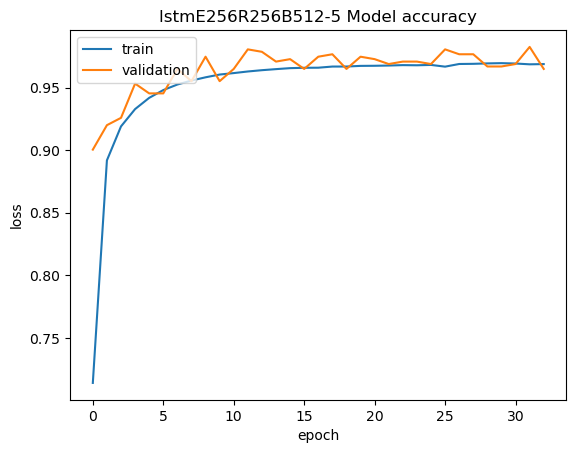

In [64]:
plt.plot(lstm_historyB256.history['accuracy'])
plt.plot(lstm_historyB256.history['val_accuracy'])
plt.title('lstmE256R256B512-5 Model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

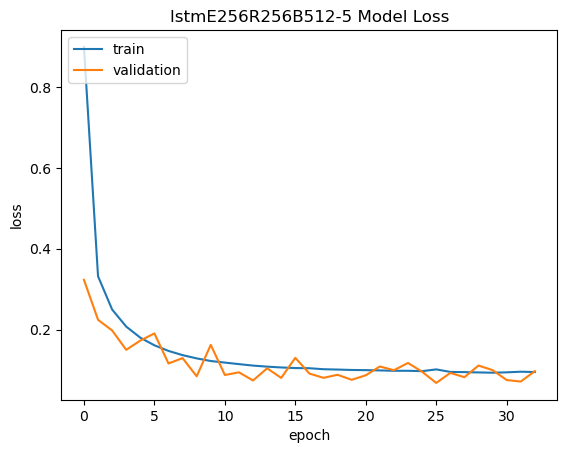

In [65]:
plt.plot(lstm_historyB256.history['loss'])
plt.plot(lstm_historyB256.history['val_loss'])
plt.title('lstmE256R256B512-5 Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()#Epoch 30 or 32

In [15]:
lstm_loss,lstm_acc = lstm.evaluate(test_dataset)
print("LSTM Loss on Test Data: ",lstm_loss)
print("LSTM Acc on Test Data: ",lstm_acc)

72/72 [==============================] - 64s 44ms/step - loss: 0.0762 - accuracy: 0.9771
LSTM Loss on Test Data:  0.07619398832321167
LSTM Acc on Test Data:  0.9771050214767456


In [39]:
def read_cipher():
  cipher = ''
  f = open('cipher.txt','r')
  for line in f:
    if(line[0].isalpha()):
      cipher+=line[0]
  f.close()
  return cipher
print(read_cipher())

WZTMSMECCIHPWYNHPEHPRBMWVMCVMTPMSMEYAHPEHHPWVCWZMWVETEYAMSWYLHRZWYAPRBMTPIVPRGCATMYRHCRRNZRSTESAHRHPMESSWXEC


WZ TM SMECCI HPWYN HPEH PRBM WV MCVMTPMSM EYA HPEH HPWV CWZM WV E TEYAMSWYL HR ZWYA PRBM TPI VPRGCA TM YRH CRRN ZRSTESA HR HPM ESSWXEC

<B>Search Algo

In [44]:
def DijkstraSearch(RNN, cipher:str, temperature = 1.0,guesses:int=10): #Without States
  skip_ids = ids_from_chars(['[UNK]'])[:, None]
  sparse_mask = tf.SparseTensor(
      # Put a -inf at each bad index.
      values=[-float('inf')]*len(skip_ids),
      indices=skip_ids,
      # Match the shape to the vocabulary
      dense_shape=[27])
  prediction_mask = tf.sparse.to_dense(sparse_mask)
  
  @tf.function
  def one_step(RNN,inputs):
    input_chars = tf.strings.unicode_split(inputs,'UTF-8')
    input_ids = ids_from_chars(input_chars).to_tensor()
    predicted_logits = RNN(inputs=input_ids)
    #predicted_logits = predicted_logits[:,-1,:]
    predicted_logits = predicted_logits/temperature
    predicted_logits += prediction_mask
    return predicted_logits #-1 is the last character in the sequence
  
  letters = ' abcdefghijklmnopqrstuvwxyz'
  cleaned_cipher = " ".join(process_sentence(list(set(cipher.split(" "))),lower=False)) #Gets rid of duplicate words in the sentence, and cleans up sentence
  available_letters = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]

  # THIS NEEDS TO BE MODIFIED TO INTRODUCE THE CORRECT LETTER WHEN IT IS THAT LETTERS TURN TO BE GUESSED MAYBE???
  for i in range(len(letters)):
    if(i!=0 and cleaned_cipher.find(letters[i])>-1):
      available_letters[i] = letters[i]


  #cleaned_cipher = cleaned_cipher.upper()

  nextNodes = [(0,cleaned_cipher,available_letters)] # We can set our starting prob to zero because all sequences share the starting probability value
  final_guesses = []
  while len(nextNodes)>0:
    currentNode = nextNodes.pop()
    new_cipher = " ".join(sorted(currentNode[1].split(" "),key=lambda word: len(set(regex.sub('[[:punct:]a-z ]','',word))))) # sorted by num of unique uppercase letters
    #print(currentNode[0],new_cipher,currentNode[2])

    letter_count = defaultdict(lambda:[0,0])#Count and letter position
    for i in range(len(new_cipher)):
      if new_cipher[i].isalpha() and new_cipher[i].isupper(): #all replacable char are uppercase and letters
        letter_count[new_cipher[i]][0] += 1
        letter_count[new_cipher[i]][1] = i
        
    temp_split = new_cipher.split(" ")
    refined_letter_count = {}
    replacable_index = -1

    for word in temp_split: #Finds first word that is replacable
      temp_word = regex.sub('[[:punct:]a-z ]','',word)
      if(len(temp_word)>0):
        for letter in temp_word:
          refined_letter_count[letter]=letter_count[letter]
        replacable_index = max(refined_letter_count.values(),key=lambda v: v[0])[1] #The most common uppercase character located within the first word will be guessed
        break
    
    if(replacable_index==-1):#There are no more replacable characters AKA End Condition
      final_guesses.append(currentNode)
      if(len(final_guesses)==guesses):
        return final_guesses
      continue

    
    replaced_letter = new_cipher[replacable_index]

    # if(str(available_letters[letters.find(replaced_letter.lower())]).isalpha()): #If this was a letter that was presolved
    #   cipher_guess = new_cipher.replace(replaced_letter,replaced_letter.lower())
    #   remaining_indexes = copy.deepcopy(currentNode[2]) #idk if this is needed, but i didnt want to risk it
    #   nextNodes.append((currentNode[0],cipher_guess,remaining_indexes))
    #   continue
    
    new_cipher = new_cipher.replace(replaced_letter,"_")#which class we are going to choose

    tf_cipher = tf.constant([new_cipher])
    predicted_logits = one_step(RNN,tf_cipher) # Predicted Logits for the last letter in the sequence
    softmax = tf.nn.softmax(predicted_logits,1)      
    new_nodes, node_indices = tf.nn.top_k(softmax, k=26)
    node_ids = tf.get_static_value(node_indices)
    node_scores = tf.get_static_value(new_nodes)
    
    for i in range(len(node_ids[0])):
      index = node_ids[0][i]
      if(not index in currentNode[2]):
        continue
      cipher_guess = new_cipher.replace("_",letters[index]) #Appends new char to sequence
      remaining_indexes = copy.deepcopy(currentNode[2])
      remaining_indexes[index]=replaced_letter
      new_score = currentNode[0] + np.log2(node_scores[0][i]) #+ np.log2(27-len(remaining_indexes))
      nextNodes.append((new_score,cipher_guess,remaining_indexes))
    nextNodes = sorted(nextNodes, key=lambda seq: seq[0]) #Sort in ascending order because pop() pops last value off the array
    #return nextNodes
  return final_guesses
        

In [40]:
guesses = DijkstraSearch(lstm,"m whmerbj zmnqrbh, mcumfy ugobe od mbe jgrbj, qh zmyihwhe uqmihahw umy bgi ugwiq iqh pbgurbj.".upper(),guesses=20)

In [45]:
guesses = DijkstraSearch(lstm,"WZ TM SMECCI HPWYN HPEH PRBM WV MCVMTPMSM EYA HPEH HPWV CWZM WV E TEYAMSWYL HR ZWYA PRBM TPI VPRGCA TM YRH CRRN ZRSTESA HR HPM ESSWXEC",guesses=20)

In [60]:
#guesses = DijkstraSearch(lstm,'SZMW GSRH XZIW GL Z HGIZMTVI DSROV HZBRMT GSV PVB KSIZHV: "YILXXLOR RH NZM NZWV"',guesses=10)
guesses  = DijkstraSearch(lstm,'SZMW GSRH cZIW GL Z HGIZMTVI DSROV HZBRMT GSV PVB KSIZHV: "YILccLOR RH NZM NZWV"',guesses=10)
guesses1 = DijkstraSearch(lstm,'SaMW GSRH caIW GL a HGIaMTVI DSROV HaBRMT GSV PVB KSIaHV: "YILccLOR RH NaM NaWV"',guesses=10)
#guesses = DijkstraSearch(lstm,'SZMd GSRH cZId GL Z HGIZMTVI DSROV HZBRMT GSV PVB KSIZHV: "YILccLOR RH NZM NZdV"',guesses=10)


In [62]:
guesses2 = DijkstraSearch(lstm,'SaMW GSRH carW GL a HGraMTVr DSROV HaBRMT GSV PVB KSraHV: "YrLccLOR RH NaM NaWV"',guesses=10)

In [58]:
for i in guesses:
  print(i)

(-7.854477527767017, 'a on ys olys ole had ladg hage few sawydt soradter plrase carg blyke urnccnky', [0, 'a', 'D', 'c', 'M', 'V', 'P', 'W', 'N', 9, 10, 'O', 'S', 13, 'L', 'G', 'K', 17, 'I', 'H', 'T', 'Y', 22, 'B', 24, 'R', 26])
(-9.41834502762049, 'a on yl oryl ore hag ragk hake few lawygs louagseu bruale cauk pryte dunccnty', [0, 'a', 'K', 'c', 'Y', 'V', 'P', 'M', 'N', 9, 10, 'W', 'H', 13, 'L', 'G', 'D', 17, 'S', 'T', 'O', 'I', 22, 'B', 24, 'R', 26])
(-9.586628523150921, 'a on ym olym ole gas last gate bed madysk morasker flrame cart plyve urnccnvy', [0, 'a', 'P', 'c', 'B', 'V', 'K', 'N', 8, 9, 10, 'T', 'S', 'H', 'L', 'G', 'D', 17, 'I', 'M', 'W', 'Y', 'O', 23, 24, 'R', 26])
(-9.70209210202404, 'a on ys olys ole had ladk hake few sawydt soradter glrase cark plyme urnccnmy', [0, 'a', 2, 'c', 'M', 'V', 'P', 'K', 'N', 9, 10, 'W', 'S', 'O', 'L', 'G', 'D', 17, 'I', 'H', 'T', 'Y', 22, 'B', 24, 'R', 26])
(-9.763775122345692, 'a on ys olys ole had ladk hake few sawydt soradter ulrase cark ply

In [61]:
for i in guesses1:
  print(i)

(-7.854477527767017, 'a on ys olys ole had ladg hage few sawydt soradter plrase carg blyke urnccnky', [0, 'a', 'D', 'c', 'M', 'V', 'P', 'W', 'N', 9, 10, 'O', 'S', 13, 'L', 'G', 'K', 17, 'I', 'H', 'T', 'Y', 22, 'B', 24, 'R', 26])
(-9.41834502762049, 'a on yl oryl ore hag ragk hake few lawygs louagseu bruale cauk pryte dunccnty', [0, 'a', 'K', 'c', 'Y', 'V', 'P', 'M', 'N', 9, 10, 'W', 'H', 13, 'L', 'G', 'D', 17, 'S', 'T', 'O', 'I', 22, 'B', 24, 'R', 26])
(-9.586628523150921, 'a on ym olym ole gas last gate bed madysk morasker flrame cart plyve urnccnvy', [0, 'a', 'P', 'c', 'B', 'V', 'K', 'N', 8, 9, 10, 'T', 'S', 'H', 'L', 'G', 'D', 17, 'I', 'M', 'W', 'Y', 'O', 23, 24, 'R', 26])
(-9.70209210202404, 'a on ys olys ole had ladk hake few sawydt soradter glrase cark plyme urnccnmy', [0, 'a', 2, 'c', 'M', 'V', 'P', 'K', 'N', 9, 10, 'W', 'S', 'O', 'L', 'G', 'D', 17, 'I', 'H', 'T', 'Y', 22, 'B', 24, 'R', 26])
(-9.763775122345692, 'a on ys olys ole had ladk hake few sawydt soradter ulrase cark ply

In [63]:
for i in guesses2:
  print(i)

(-9.365603612099108, 'a of rs ours oue burase jan uand jade soranger card sayrng mey purle trfccflr', [0, 'a', 'K', 'c', 'W', 'V', 'L', 'T', 8, 9, 'N', 11, 'O', 'P', 'M', 'G', 'D', 17, 'r', 'H', 'Y', 'S', 22, 23, 24, 'B', 26])
(-9.468071847892247, 'a on rm ourm oue furame was uasy waye morasher cary madrsh bed purge trnccngr', [0, 'a', 'P', 'c', 'B', 'V', 'K', 'O', 'T', 9, 10, 11, 12, 'H', 'L', 'G', 'D', 17, 'r', 'M', 'Y', 'S', 22, 'N', 24, 'W', 26])
(-9.933882219772613, 'a on rd ourd oue burade was uasy waye dorasker cary davrsk pev furge trnccngr', [0, 'a', 'K', 'c', 'H', 'V', 'D', 'O', 8, 9, 10, 'T', 12, 13, 'L', 'G', 'P', 17, 'r', 'M', 'Y', 'S', 'B', 'N', 24, 'W', 26])
(-10.89360029514853, 'a of rs ours oue burase man uany maye soranger cary sadrng ped wurle trfccflr', [0, 'a', 'K', 'c', 'B', 'V', 'L', 'T', 8, 9, 10, 11, 'O', 'N', 'M', 'G', 'P', 17, 'r', 'H', 'Y', 'S', 22, 'D', 24, 'W', 26])
(-10.89697819297362, 'a of rd ourd oue gurade man uany maye doranter cary dairnt zei purle 

In [55]:
guesses1 = DijkstraSearch(lstmB512,"OZGGLK D ZWL EFTBL BQZOLB TU EFL CVE CLESLLR EFLM KTR'E DRELWYZGB MTV BLOTKRB SFZE XRTS DR ZGSZMB EFDRX".upper())

In [54]:
print(guesses1)

[(-inf, 'a QH OD BGI IQH aBE UaY JGRBJ UGOBE UGWIQ aCUaFY PBGURBJ UQaIHNHW WHaERBJ ZaYIHWHE ZaNQRBH', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), (-26.931699752807617, 'j QH OD BGI IQH jBE UjY JGRBJ UGOBE UGWIQ jCUjFY PBGURBJ UQjIHNHW WHjERBJ ZjYIHWHE ZjNQRBH', [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), (-24.422500610351562, 'g QH OD BGI IQH gBE UgY JGRBJ UGOBE UGWIQ gCUgFY PBGURBJ UQgIHNHW WHgERBJ ZgYIHWHE ZgNQRBH', [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), (-22.69183349609375, 'z QH OD BGI IQH zBE UzY JGRBJ UGOBE UGWIQ zCUzFY PBGURBJ UQzIHNHW WHzERBJ ZzYIHWHE ZzNQRBH', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (-20.68408966064453, 'm QH OD BGI IQH mBE UmY JGRBJ UGOBE UGWIQ mCUmFY PBGURBJ UQmIHNHW WHmERBJ ZmYIHWHE ZmNQRBH', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18

In [59]:
guesses1 = DijkstraSearch(lstmB512,"OZGGLd D ZWL tFoBL BQZOLB oU tFL CVt CLtSLLn tFLM don't DntLWYZGB MTV BLOondB SFZt XRTS Dn ZGSZMB tFDnX".upper(),guesses=10)

In [57]:
guesses2 = DijkstraSearch(lstm,"Rckdlvpycd hl lzcssf kym xkm ke legnn kym whmci okzcl.".upper(),guesses=10)

In [61]:
for i in guesses2:
  print(i)

(-10.422286864461057, 'an he way afy enujj table chyld eblook plasemifls', [0, 'K', 'Z', 'W', 'I', 'L', 'Y', 7, 'H', 'P', 'N', 'F', 'C', 'V', 'E', 'S', 'R', 17, 18, 'D', 'O', 'G', 22, 'X', 24, 'M', 26])
(-10.580895469627535, 'an go bad aud onfll jawro sgdry owrtth pracomvurc', [0, 'K', 'X', 'D', 'M', 5, 'G', 'H', 'F', 9, 'O', 11, 'N', 'V', 'E', 'L', 'R', 17, 'C', 'W', 'S', 'Y', 'P', 'Z', 24, 'I', 26])
(-10.665233287870933, 'an be day auy engff valce mbych elcook scaterjuct', [0, 'K', 'H', 'C', 'X', 'L', 'N', 'G', 'I', 9, 'P', 'F', 'Z', 'W', 'E', 'S', 16, 17, 'V', 'R', 'D', 'Y', 'O', 23, 24, 'M', 26])
(-11.623814258635093, 'an be day auy engff valce mbych elcook scaperjucp', [0, 'K', 'H', 'C', 'X', 'L', 'N', 'G', 'I', 9, 'P', 'F', 'Z', 'W', 'E', 'S', 't', 17, 'V', 'R', 'D', 'Y', 'O', 23, 24, 'M', 26])
(-11.633957323927461, 'an he way afy enujj gable chyld eblook plasemifls', [0, 'K', 'Z', 'W', 'I', 'L', 'Y', 'O', 'H', 'P', 'N', 'F', 'C', 'V', 'E', 'S', 'R', 17, 18, 'D', 20, 'G', 22, 'X'